# **Closed-world: Select Model**
Preprocess the monitored data, extract features, and identify the model with the highest accuracy. Three candidate models were considered.
In this notebook, the task is performed using the **'Naive Bayes'**, and the results are presented.

## 1. Data Preprocessing

In [ ]:
# Convert specific features of the monitored dataset 'mon_standart.pkl' into arrays.

import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open("/mon_standard.pkl", 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Loading datafile...
Total samples: 19000


## 2. Feature Extraction

In [ ]:
# Feature extraction

import pandas as pd
import numpy as np

# A function to calculate the number of incoming/outgoing packets for the first 30 packets in each row
def count_in_out_first_30(X2):
    n_in_first = [] # Number of incoming packets for the first 30 packets
    n_out_first = [] # # Number of outgoing packets for the first 30 packets

    for packets in X2:
        # Calculate n_in_first and n_out_first for the first 30 packets
        n_in_f = sum(1 for packet in packets[:30] if packet > 0)
        n_out_f = sum(1 for packet in packets[:30] if packet < 0)

        # Append each result to the respective lists
        n_in_first.append(n_in_f)
        n_out_first.append(n_out_f)

    return n_in_first, n_out_first

# A function to calculate basic features
def compute_features(X2, X1):
    n_pkt = []  # Total number of packets
    n_in = []  # Number of incoming packets
    n_out = []  # Number of outgoing packets
    r_in = []  # Number of incoming packets as a fraction of the total number
    r_out = []  # Number of outgoing packets as a fraction of the total number
    n_pkt_persec = []  # Packets per second

    for i in range(0, len(X2)):
        cnt_in = 0
        for j in range(0, len(X2[i])):
            if X2[i][j] < 0:
                cnt_in += 1
        n_pkt.append(len(X2[i]))
        n_in.append(cnt_in)
        n_out.append(len(X2[i]) - cnt_in)
        r_in.append(cnt_in / len(X2[i]) if len(X2[i]) > 0 else 0)
        r_out.append(1 - (cnt_in / len(X2[i])) if len(X2[i]) > 0 else 0)
        t = X1[i][-1] - X1[i][0] if len(X1[i]) > 1 else 1
        n_pkt_persec.append(n_pkt[i] / t if t > 0 else 0)

    n_in_first, n_out_first = count_in_out_first_30(X2)

    # Create a dataframe
    df_mon = pd.DataFrame({
        'n_pkt': n_pkt,
        'n_in': n_in,
        'n_out': n_out,
        'r_in': r_in,
        'r_out': r_out,
        'n_in_first': n_in_first,
        'n_out_first': n_out_first,
        'n_pkt_persec': n_pkt_persec
    })

    return df_mon

# A function to calculate the standard deviation of outgoing packets
def outgoing_packet_std(X2):
    std_list = []

    for packets in X2:
        outgoing_indices = [i for i, packet in enumerate(packets) if packet < 0]

        if len(outgoing_indices) == 0:
            std_list.append(0)
        else:
            std_list.append(np.std(outgoing_indices))

    return std_list

# A function to calculate the number of packets in the last 5 seconds
def count_packets_last_5_seconds(X1):
    n_last_5s = []
    for timestamps in X1:
        if not timestamps:
            n_last_5s.append(0)
        else:
            end_time = timestamps[-1]
            start_time = end_time - 5
            n_last_5s.append(sum(1 for t in timestamps if t > start_time))
    return n_last_5s

# A function to calculate newly added features
def add_new_features(df_mon, X2, X1):
    sum_alt_concentration = [sum(abs(packet) for packet in packets) for packets in X2]
    df_mon['sum_alt_concentration'] = sum_alt_concentration # Sum of absolute packet size

    alt_pkt_persec = [
        sum(abs(packet) for packet in packets) / (X1[i][-1] - X1[i][0]) if len(packets) > 1 and X1[i][-1] > X1[i][0] else 0 for i, packets in enumerate(X2)
    ]
    df_mon['alt_pkt_persec'] = alt_pkt_persec # Average absolute packet size per second

    df_mon['std_ordering'] = [pd.Series(packets).std() for packets in X2] # Standard Deviation of Packet Sizes

    outgoing_std = outgoing_packet_std(X2)
    df_mon['std_dev of outgoing'] = outgoing_std # Standard Derivation of Outgoing Packets

    cumulative_pkt_size = [sum(map(abs, packets)) for packets in X2]
    df_mon['cumulative_pkt_size'] = cumulative_pkt_size # Cumulative packet Size

    avg_burst_interval = []
    for i in range(len(X1)):
        burst_intervals = [X1[i][j+1] - X1[i][j] for j in range(len(X1[i])-1) if abs(X2[i][j]) > 0]
        avg_burst_interval.append(sum(burst_intervals) / len(burst_intervals) if burst_intervals else 0)
    df_mon['avg_burst_interval'] = avg_burst_interval # Average of Burst Interval

    std_time_interval = [np.std([X1[i][k+1] - X1[i][k] for k in range(len(X1[i])-1)]) if len(X1[i]) > 1 else 0 for i in range(len(X1))]
    df_mon['std_time_interval'] = std_time_interval # Standard Deviation of Time Intervals

    sum_alternate_pkt_per_sec = []
    for packets in X2:
        count = 0
        for i in range(1, len(packets)):
            if (packets[i] > 0 and packets[i-1] < 0) or (packets[i] < 0 and packets[i-1] > 0):
                count += 1
        sum_alternate_pkt_per_sec.append(count)

    df_mon['sum_alternate_pkt_per_sec'] = sum_alternate_pkt_per_sec # Number of packets changing direction per second in each sample

    df_mon['#of_packets_in_last_5_seconds'] = count_packets_last_5_seconds(X1) # Number of packets during the last 5 seconds

    return df_mon

In [ ]:
# Basic Features Calculation
df_mon = compute_features(X2, X1)
# Additional Features Calculation
df_mon = add_new_features(df_mon, X2, X1)

# Additional Feature: Calculating Pearson Correlation Coefficient Between Packet Size and Timestamp
df_mon['size_time_corr'] = [
    pd.Series(packets).corr(pd.Series(times)) if len(packets) > 1 else np.nan
    for packets, times in zip(X2, X1)
]
## Analyzing the correlation between packet size and timestamp in network data can help identify patterns.
## For example, if larger packet sizes frequently occur at specific times, there may be a positive correlation.

# Add Label
df_mon['label'] = y

In [ ]:
# Check the DataFrame created with the features
df_mon.head()

,n_pkt,n_in,n_out,r_in,r_out,n_in_first,n_out_first,n_pkt_persec,sum_alt_concentration,alt_pkt_persec,std_ordering,std_dev of outgoing,cumulative_pkt_size,avg_burst_interval,std_time_interval,sum_alternate_pkt_per_sec,#of_packets_in_last_5_seconds,size_time_corr,label
0,1421,1300,121,0.914849,0.085151,9,21,140.138067,727552,71750.690335,285.905893,398.486335,727552,0.007141,0.041168,155,179,0.068924,0
1,518,438,80,0.845560,0.154440,8,22,50.984252,265216,26103.937008,370.400747,150.591146,265216,0.019652,0.163930,93,236,-0.104867,0
2,1358,1240,118,0.913108,0.086892,7,23,122.232223,695296,62582.898290,288.543964,381.878642,695296,0.008187,0.066661,151,303,0.081140,0
3,1446,1324,122,0.915629,0.084371,9,21,108.233533,740352,55415.568862,284.712015,406.205288,740352,0.009246,0.047809,159,161,0.090254,0
4,1406,1291,115,0.918208,0.081792,8,22,132.142857,719872,67657.142857,280.725055,395.028889,719872,0.007573,0.038760,157,167,0.090400,0


In [ ]:
df_mon.tail()

,n_pkt,n_in,n_out,r_in,r_out,n_in_first,n_out_first,n_pkt_persec,sum_alt_concentration,alt_pkt_persec,std_ordering,std_dev of outgoing,cumulative_pkt_size,avg_burst_interval,std_time_interval,sum_alternate_pkt_per_sec,#of_packets_in_last_5_seconds,size_time_corr,label
18995,9434,8815,619,0.934386,0.065614,7,23,214.848554,4830208,110002.459576,253.561660,2698.463332,4830208,0.004655,0.143962,745,4,0.052816,94
18996,9956,9404,552,0.944556,0.055444,7,23,638.205128,5097472,326761.025641,234.348798,2863.806259,5097472,0.001567,0.019465,722,1740,-0.025223,94
18997,9952,9373,579,0.941821,0.058179,8,22,666.577361,5095424,341287.608841,239.712124,2857.611288,5095424,0.001500,0.016411,741,1997,-0.007395,94
18998,9926,9236,690,0.930486,0.069514,7,23,498.543446,5082112,255254.244098,260.443829,2844.328152,5082112,0.002006,0.033281,812,3962,0.028430,94
18999,9925,9168,757,0.923728,0.076272,7,23,721.293605,5081600,369302.325581,271.816968,2825.280155,5081600,0.001387,0.011074,810,2814,0.067157,94


Final Extracted Feature List (total: 18)

- n_pkt: Total number of packets
- n_in: Number of incoming packets
- n_out: Number of outgoing packets
- r_in: Number of incoming packets as a fraction of the total number
- r_out: Number of outgoing packets as a fraction of the total number
- n_in_first: Number of incoming packets for the first 30 packets
- n_out_first: Number of outgoig packets for the first 30 packets
- n_pkt_persec: Number of packets per second
- sum_alt_concentration:Sum of absolute packet sizes
- alt_pkt_persec: Average absolute packet size per second
- std_ordering: Standard Deviation of Packet Sizes
- std_dev of outgoing: Standard Derivation of Outgoing Packets
- cumulative_pkt_size: Cumulative Packet Size
- avg_burst_interval: Average of Burst Interval
- std_time_interval: Standard Deviation of Time Intervals
- sum_alternate_pkt_per_sec: Number of packets changing direction per second in each sample
- #of_packets_in_last_5_seconds: Number of packets during the last 5 seconds
- size_time_corr: Pearson Correlation Coefficient Between Packet Size and Timestamp

## 3. Feature Importance Extraction

In [ ]:
# Extract feature importance using feature_importances_

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = df_mon[df_mon.columns[:-1]]
y = df_mon['label']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=2)

clf = RandomForestClassifier(n_estimators=1000, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print(sum(scores)/len(scores))
# feature importance is computed using the gini impurity (total decrease in node impurity averaged over all trees in the ensemble)
imp_score=clf.feature_importances_

# pick top 5 features
# np.argsort returns "indices" in ascending order
top_indices=np.argsort(imp_score)[::-1][:5]
print(top_indices)
top_feature_names = [df_mon.columns[int(x)] for x in top_indices]
print(top_feature_names)

C:\Users\sonab\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sonab\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sonab\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sonab\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
  

[0.35894737        nan        nan        nan        nan]
nan
[ 2 10  4  3 11]
['n_out', 'std_ordering', 'r_out', 'r_in', 'std_dev of outgoing']


C:\Users\sonab\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sonab\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sonab\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


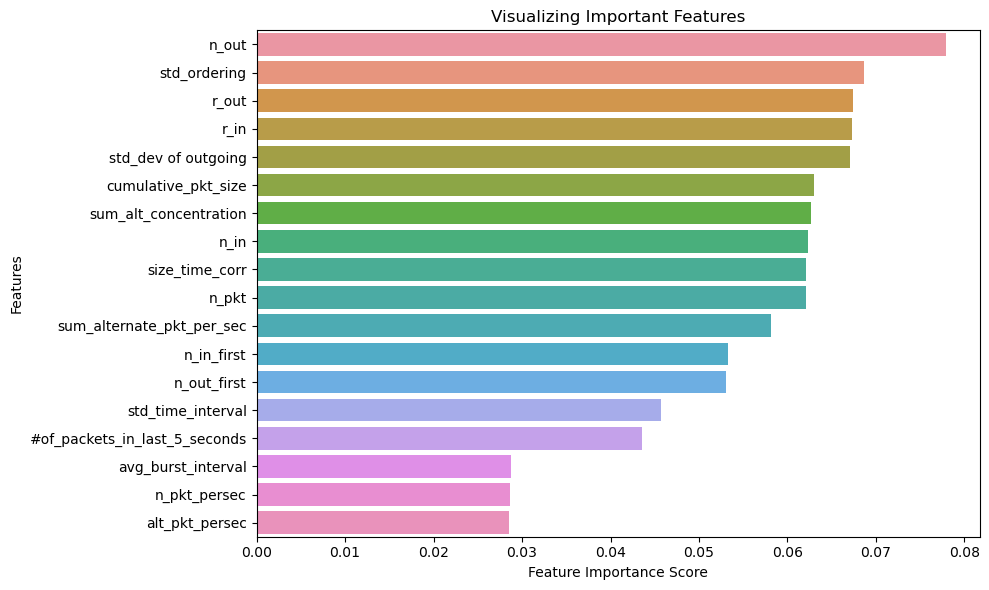

In [ ]:
# Visualization

import seaborn as sns
import matplotlib.pyplot as plt

feature_imp = pd.Series(clf.feature_importances_, index=df_mon.columns[:-1]).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

## 4. Compute Accuray : Naive Bayes

In [ ]:
# Naive Bayes - Compute Accuracy

from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from collections import Counter

test1 = list(range(18)) # Case 1 : Use all features
test2 = list(range(11)) # Case 2 : Use Top 10 Features
test3 = [0,1,2,3,4] # Case 3 : Use Top 3 features

y = df_mon['label']

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Compute NB model accuracy
def naive_bayes_classifier(X, y, selected_features):
    X_selected = X.iloc[:, selected_features]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=2)

    model = GaussianNB()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, X_test, y_test, y_pred

In [ ]:
# Visualization - Correctly predicted data among all predictions

def plot_class_predictions(y_test, y_pred):
    # Calculate the number of test data points for each class
    test_counts = Counter(y_test)

    # Calculate the number of correctly predicted data points for each class
    correct_predictions = (y_test == y_pred)
    correct_counts = Counter(y_test[correct_predictions])

    # Range of 95 classes (index = 0 to 94)
    num_classes = 95
    classes = np.arange(num_classes)

    # The number of test data points for each class is represented as a bar graph
    plt.figure(figsize=(12, 6))
    plt.bar(classes, [test_counts[i] for i in classes], color='green', label='Test Counts')

    # The number of correctly predicted data points is indicated by yellow dots
    plt.scatter(classes, [correct_counts[i] if i in correct_counts else 0 for i in classes], color='yellow', label='Correct Predictions', s=20)
    plt.xticks(np.arange(0, num_classes, 10))

    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Counts and Correct Predictions per Class - Naive Bayes')
    plt.legend()
    plt.show()

Case 1 : Use all features

In [ ]:
# Case 1 : Use all features
accuracy_test1, X_test1, y_test1, y_pred1 = naive_bayes_classifier(X, y, test1)
print("accuracy score: ", accuracy_test1)

accuracy score:  0.12526315789473685


Plotting for all features


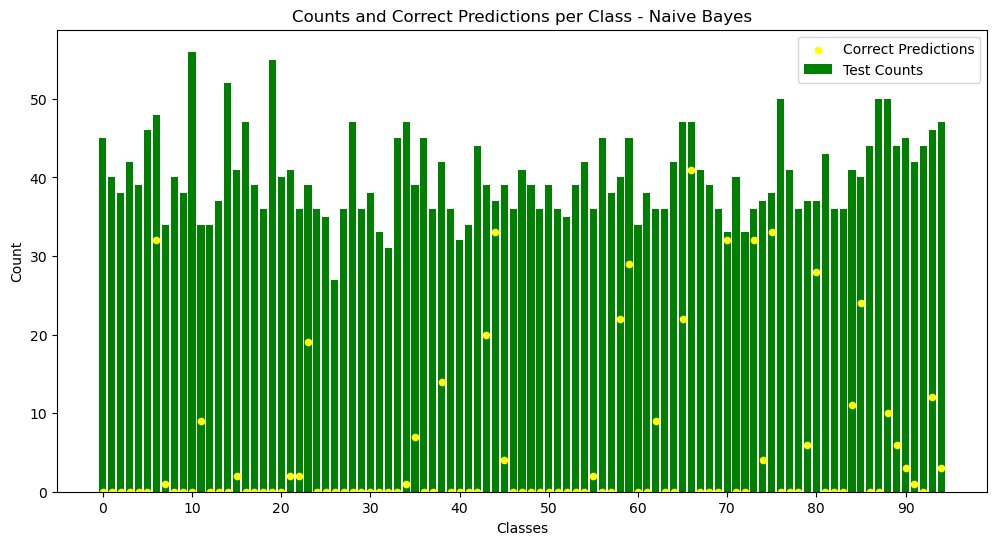

In [ ]:
print("Plotting for all features")
plot_class_predictions(y_test1, y_pred1)

Case 2: Use Top 10 features

In [ ]:
# Case 2 : Use Top 10 features
accuracy_test2, X_test2, y_test2, y_pred2 = naive_bayes_classifier(X, y, test2)
print("accuracy score: ", accuracy_test2)

accuracy score:  0.13605263157894737


Plotting for top 10 features


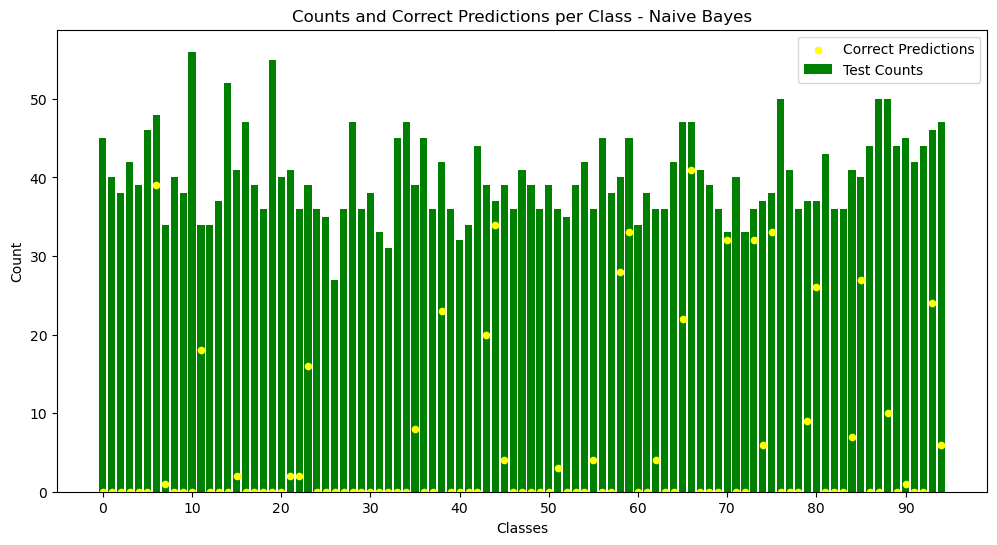

In [ ]:
print("Plotting for top 10 features")
plot_class_predictions(y_test2, y_pred2)

Case 3 : Use Top 5 features

In [ ]:
# Case 3 : Use Top 5 features
accuracy_test3, X_test3, y_test3, y_pred3 = naive_bayes_classifier(X, y, test3)
print("accuracy score: ", accuracy_test3)

accuracy score:  0.12105263157894737


Plotting for top 5 features


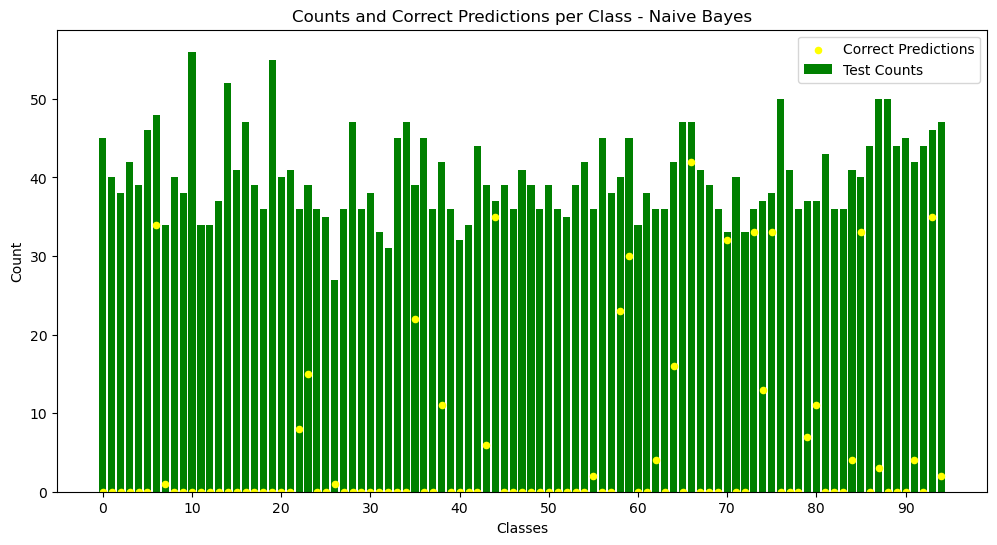

In [ ]:
print("Plotting for top 5 features")
plot_class_predictions(y_test3, y_pred3)

## 5. Result : Naive Bayes

Accuracy Score
- Case 1 (Use all features) : 0.12526315789473685
- Case 2 (Use Top 10 features) : 0.13605263157894737
- Case 3 (Use Top 5 features) : 0.12105263157894737